## **Tutorial 1: Data integration Using Harmony**

### Import Packages and load datasets

In [1]:
import os
import sys

In [2]:
sys.path.append(os.getcwd())

In [3]:
import stereoAlign
import scanpy as sc
import numpy as np
from anndata import AnnData

In [4]:
dataset = AnnData.concatenate(*[sc.read_h5ad(os.path.join("demo_data", f)) for f in sorted(os.listdir("demo_data/"))])

### Preprocessing datasets

In [5]:
stereoAlign.pp.summarize_counts(dataset)

In [6]:
stereoAlign.pp.norma_log(dataset)

### Optional:        
Scaling counts to a mean of 0 and standard deviation of 1 using ``scanpy.pp.scale`` for each batch separately. It is possible to effectively alleviate the impact of minor batch effects.

In [7]:
dataset = stereoAlign.pp.scale_batch(dataset, batch="batch")

### Visualization original dataset               
Before proceeding with the integration process, it is essential to visualize the original dataset in its unadulterated form. This visualization serves as a valuable reference point for understanding the inherent characteristics and structure of the data.

In [8]:
stereoAlign.pp.reduce_data(dataset, pca=True, pca_comps=100, neighbors=True, use_rep="X_pca", umap=True)

PCA
Nearest Neigbours
UMAP


In [9]:
sc.tl.leiden(dataset)

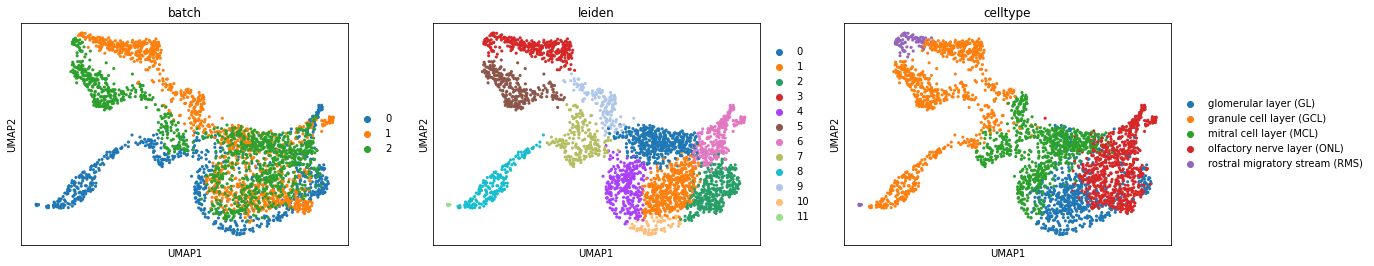

In [10]:
sc.pl.umap(dataset, color=["batch", "leiden", "celltype"])

### Calculation metric score using original datasets

In [11]:
stat_mean, pvalue_mean, accept_rate = stereoAlign.metrics.kbet(
    dataset, 
    key="batch", 
    use_rep="X_umap", 
    alpha=0.1,
    n_neighbors=15)

In [12]:
stat_mean, pvalue_mean, accept_rate

(17.30697483381354, 0.08259827579077056, 0.1910868868226996)

In [13]:
stereoAlign.metrics.graph_connectivity(dataset, label_key="celltype")

0.9896508327875588

In [14]:
stereoAlign.metrics.silhouette(dataset, label_key="celltype", embed="X_umap")

0.5907675176858902

### Using ``Harmony`` to integration datasets            
The corrected feature matrix will be saved in  ``*.obsm["aligned_harmony"]``

In [15]:
harmony_dataset = dataset.copy()
harmony_corrected = stereoAlign.alg.harmony_alignment(harmony_dataset, batch_key="batch")

	Initialization is completed.
	Completed 1 / 10 iteration(s).
	Completed 2 / 10 iteration(s).
	Completed 3 / 10 iteration(s).
	Completed 4 / 10 iteration(s).
	Completed 5 / 10 iteration(s).
	Completed 6 / 10 iteration(s).
	Completed 7 / 10 iteration(s).
	Completed 8 / 10 iteration(s).
	Completed 9 / 10 iteration(s).
	Completed 10 / 10 iteration(s).


In [16]:
harmony_corrected

AnnData object with n_obs × n_vars = 3119 × 20341
    obs: 'celltype', 'batch', 'n_counts', 'log_counts', 'n_genes', 'leiden'
    var: 'n_cells', 'mean-0', 'std-0', 'mean-1', 'std-1', 'mean-2', 'std-2'
    uns: 'pca', 'neighbors', 'umap', 'leiden', 'batch_colors', 'leiden_colors', 'celltype_colors'
    obsm: 'spatial', 'X_pca', 'X_umap', 'X_umap_knn_connectivity', 'X_umap_knn_distances', 'aligned_harmony'
    obsp: 'distances', 'connectivities'

### Visualization of integrated datasets

In [17]:
stereoAlign.pp.reduce_data(
    harmony_corrected, pca=False, pca_comps=100, neighbors=True, use_rep="aligned_harmony", umap=True)

Nearest Neigbours
UMAP


In [18]:
sc.tl.leiden(harmony_corrected)

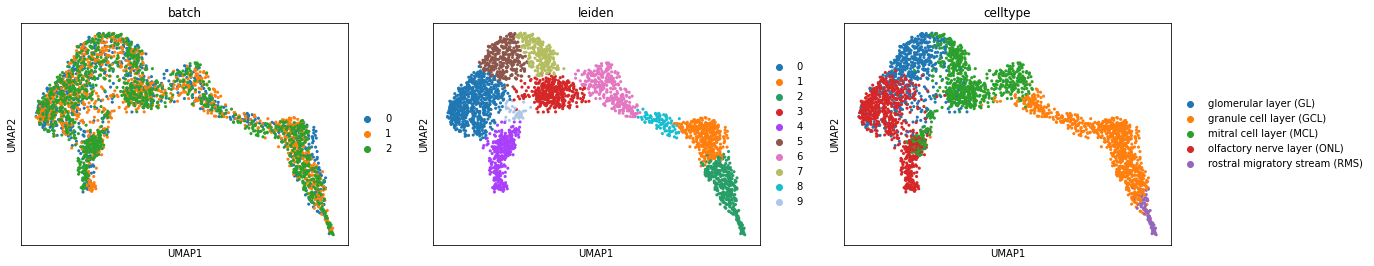

In [19]:
sc.pl.umap(harmony_dataset, color=["batch", "leiden", "celltype"])

### Calculation metirc score using integrated datasets by ``Harmony``            
In order to quantify the performance and efficacy of the integrated datasets using the powerful ``Harmony``, we can calculate the metric score.         
This score serves as a reliable measure of the harmonious blending and seamless integration achieved through the amalgamation process.

- Calculate the K-nearest neighbors Batch Effects Test (K-BET) metric of the data regarding a specific sample attribute and embedding. The K-BET metric measures if cells from different samples mix well in their local neighborhood.        
            
            
- Should the p-value surpass the predetermined alpha threshold, it is indicative that the data batch effect has indeed been successfully eradicated. This serves as a testament to the efficacy of the applied methodologies and techniques employed in the removal process.            

In [20]:
stat_mean, pvalue_mean, accept_rate = stereoAlign.metrics.kbet(
    harmony_corrected, 
    key="batch", 
    use_rep="aligned_harmony", 
    alpha=0.05,
    n_neighbors=15)

In [21]:
stat_mean, pvalue_mean, accept_rate

(11.041335043865018, 0.07790559676142805, 0.2792561718499519)

- Calculate the Local inverse Simpson's Index (LISI) metric of the data regarding a specific sample attribute and embedding. The LISI metric measures if cells from different samples mix well in their local neighborhood.                
               
               
- The larger the ``ilisi_mean`` value, the better.

In [22]:
ilisi_mean, lower, upper = stereoAlign.metrics.lisi(
    harmony_corrected, 
    key="batch", 
    use_rep="X_umap", 
    n_neighbors=15)

In [23]:
ilisi_mean, lower, upper

(2.501600357575848, 2.4877128083610844, 2.5154879067906113)

- The smaller the ``clisi_mean`` value, the better.

In [24]:
clisi_mean, lower, upper = stereoAlign.metrics.lisi(
    harmony_corrected, 
    key="celltype", 
    use_rep="X_umap", 
    n_neighbors=15)

In [25]:
clisi_mean, lower, upper

(1.2669337564931125, 1.2536753704133714, 1.2801921425728535)

- Quantify the connectivity of the subgraph per cell type label.

In [26]:
stereoAlign.metrics.graph_connectivity(harmony_corrected, label_key="celltype")

0.985720075040572

- Average silhouette width (ASW)      

    The values range from [-1, 1] with

        * 1 indicates distinct, compact clusters
        * 0 indicates overlapping clusters
        * -1 indicates core-periphery (non-cluster) structure

    By default, the score is scaled between 0 and 1 (``scale=True``).

In [27]:
stereoAlign.metrics.silhouette(harmony_corrected, label_key="celltype", embed="X_umap")

0.6264222264289856

- Modified average silhouette width (ASW) of batch

    This metric measures the silhouette of a given batch.
    It assumes that a silhouette width close to 0 represents perfect overlap of the batches, thus the absolute value of
    the silhouette width is used to measure how well batches are mixed.

In [28]:
stereoAlign.metrics.silhouette_batch(
    harmony_corrected, batch_key="batch", label_key="celltype", embed="X_umap")

mean silhouette per group:                                 silhouette_score
group                                           
glomerular layer (GL)                   0.726641
granule cell layer (GCL)                0.937189
mitral cell layer (MCL)                 0.885625
olfactory nerve layer (ONL)             0.907767
rostral migratory stream (RMS)          0.616016


0.8146478069247627